# Unsupervised learning

### AutoEncoders  

An autoencoder, is an artificial neural network used for learning efficient codings. 

The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. 

<img src="imgs/autoencoder.png" width="25%">

Unsupervised learning is a type of machine learning algorithm used to draw inferences from datasets consisting of input data without labeled responses. The most common unsupervised learning method is cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data.

### Reference

Based on [https://blog.keras.io/building-autoencoders-in-keras.html](https://blog.keras.io/building-autoencoders-in-keras.html)

## Introducing _Keras Functional API_

The Keras functional API is the way to go for defining complex models, such as multi-output models, directed acyclic graphs, or models with shared layers.

All the Functional API relies on the fact that each `keras.Layer` object is a _callable_ object!

See [10. Multi-Modal Networks](10. Multi-Modal Networks.ipynb) for further details.

---

In [1]:
from keras.layers import Input, Dense
from keras.models import Model

from keras.datasets import mnist

import numpy as np

Using TensorFlow backend.


In [2]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [3]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [4]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [7]:
#note: x_train, x_train :) 
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 0.3830 - val_loss: 0.2731
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.2664 - val_loss: 0.2561
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.2463 - val_loss: 0.2336
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.2258 - val_loss: 0.2156
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.2105 - val_loss: 0.2030
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.1997 - val_loss: 0.1936
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.1914 - val_loss: 0.1863
Epoch 8/50
60000/60000 [==============================] - 1s - loss: 0.1846 - val_loss: 0.1800
Epoch 9/50
60000/60000 [==============================] - 1s - loss: 0.1789 - val_loss: 0.1749
Epoch 10/50
60000/60000 [==============================] - 1s - loss: 0.1740 - val_loss: 0.1702

#### Testing the Autoencoder 

In [8]:
from matplotlib import pyplot as plt

%matplotlib inline

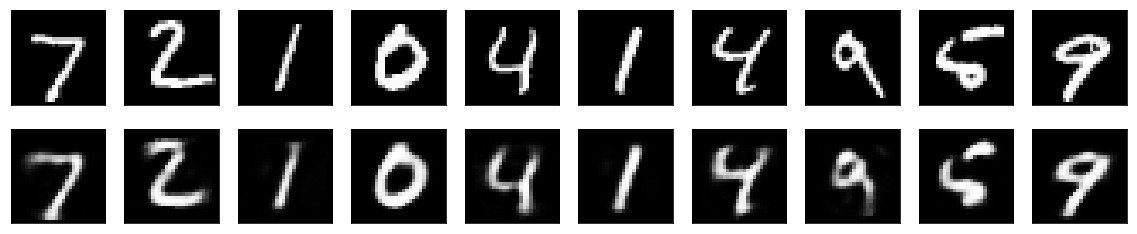

In [9]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Sample generation with Autoencoder 

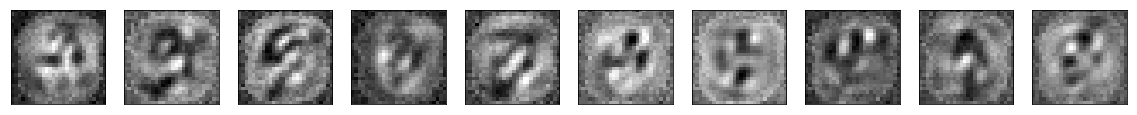

In [10]:
encoded_imgs = np.random.rand(10,32)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # generation
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---

## Convolutional AutoEncoder

Since our inputs are images, it makes sense to use convolutional neural networks (`convnets`) as encoders and decoders. 

In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

The encoder will consist in a stack of `Conv2D` and `MaxPooling2D` layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of `Conv2D` and `UpSampling2D` layers.



In [20]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [21]:
from keras import backend as K

if K.image_data_format() == 'channels_last':
    shape_ord = (28, 28, 1)
else:
    shape_ord = (1, 28, 28)
    
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, ((x_train.shape[0],) + shape_ord))  
x_test = np.reshape(x_test, ((x_test.shape[0],) + shape_ord)) 

In [22]:
x_train.shape

(60000, 28, 28, 1)

In [23]:
from keras.callbacks import TensorBoard

In [25]:
batch_size=128
steps_per_epoch = np.int(np.floor(x_train.shape[0] / batch_size))
conv_autoencoder.fit(x_train, x_train, epochs=50, batch_size=128,
                     shuffle=True, validation_data=(x_test, x_test),
                     callbacks=[TensorBoard(log_dir='./tf_autoencoder_logs')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s - loss: 0.2327 - val_loss: 0.1740
Epoch 2/50
60000/60000 [==============================] - 7s - loss: 0.1645 - val_loss: 0.1551
Epoch 3/50
60000/60000 [==============================] - 7s - loss: 0.1501 - val_loss: 0.1442
Epoch 4/50
60000/60000 [==============================] - 7s - loss: 0.1404 - val_loss: 0.1375
Epoch 5/50
60000/60000 [==============================] - 7s - loss: 0.1342 - val_loss: 0.1316
Epoch 6/50
60000/60000 [==============================] - 7s - loss: 0.1300 - val_loss: 0.1298
Epoch 7/50
60000/60000 [==============================] - 7s - loss: 0.1272 - val_loss: 0.1301
Epoch 8/50
60000/60000 [==============================] - 7s - loss: 0.1243 - val_loss: 0.1221
Epoch 9/50
60000/60000 [==============================] - 7s - loss: 0.1222 - val_loss: 0.1196
Epoch 10/50
60000/60000 [==============================] - 7s - loss: 0.1207 - val_loss: 0.1184

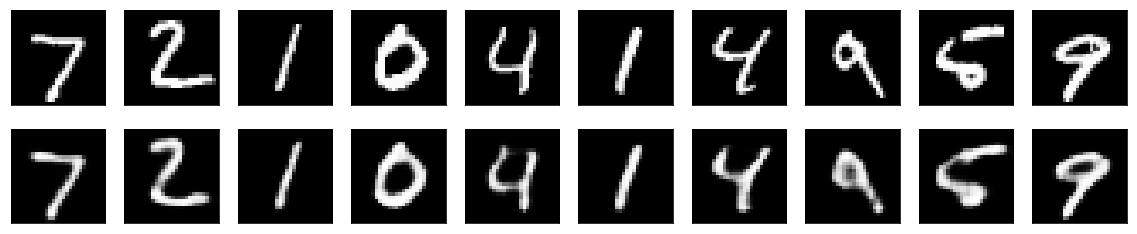

In [29]:
decoded_imgs = conv_autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We coudl also have a look at the `128-`dimensional encoded middle representation

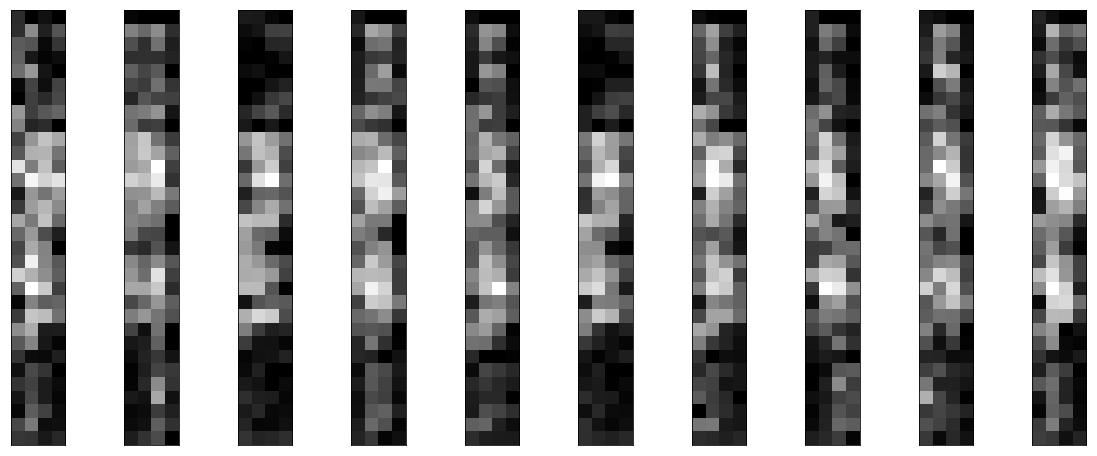

In [32]:
conv_encoder = Model(input_img, encoded)
encoded_imgs = conv_encoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Pretraining encoders 

One of the powerful tools of auto-encoders is using the encoder to generate meaningful representation from the feature vectors.

In [ ]:
# Use the encoder to pretrain a classifier 

---

## Using pre-trained word embeddings in a Keras model

**Reference:** [https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html]()